<a href="https://colab.research.google.com/github/Khurshudov/MIPT9/blob/master/10_0.93.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png", width=300, height=300></p>

<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

--- 
# [kaggle] Классификация дорожных знаков

# Использование предобученных нейросетей (transfer learning)

### В этом ноутбуке вам предлагается посоревноваться в классификации дорожных знаков Швеции. 
Вики: https://commons.wikimedia.org/wiki/Road_signs_in_Sweden 

Kaggle: https://www.kaggle.com/c/sweden-traffic-signs-classification

asdasd
Существует распространённый и очень эффективный подход к обучению глубоких нейросетей на маленьком датасете изображений. Можно использовать предобученную нейросеть. Предобученная нейросеть - это нейросеть с сохранёнными весами, которая была обучена на большом датасете, обычно на действительно большом объёме данных вроде ImageNet. Если этот оригинальный датасет достаточно большой и исчерпывающий, то пространственная иерархия фичей, выученная нейросетью может быть использована как обобщённая модель визуального мира, и, таким образом, эти фичи могут быть полезны в разных задачах машинного зрения, хотя новые задачи могут иметь совершенно другие классы, чем в оригинальном датасете.

Например, обучив нейросеть на ImageNet (где классы в основном животные и бытовые объекты), её можно использовать в задаче с совершенно другими доменами, к примеру, нахождение мебели на изображениях. Такая переносимость выученных фичей на разные задачи есть ключевое преимущество глубинного обучения над классическими подходами. И это делает глубинное обучение крайне эффективным на задачах с "маленькими" данными.

Существует два подхода к использованию предобученных сетей: **feature extraction (извлекатель фичей)** and **fine-tuning (тонкая настройка)**.

*Дополнительно:*  
* в этой статье рассказывается о классификации знаков и как улучшить скор, но код под TensorFlow :P  
 https://navoshta.com/traffic-signs-classification/
* а вот здесь можно достать **много** (в 15 раз больше, чем у нас) данных как раз о дорожных знаках, но из Германии.  
https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/  

Попробуйте разные подходы, имея в распоряжении [этот датасет](https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/):
 1. обучите на нём нейросеть из семинара №9 или любую из [известных архитектур](https://pytorch.org/docs/stable/torchvision/models.html)
 2. предсказывайте похожие классы напрямую (знаки ограничения скорости 90)  
 3. fine-tuning сети, обученной на дорогах Германии под дороги Швеции

## Ниже предоставлен base-line для соревнования

Это простой классификатор(CNN) из семинара №9, т.е. **предобученные сети не использованы**.

Вам предлагается используя код и материалы с семинара достичь лучших результатов и вырваться в лидеры нашего kaggle!

In [0]:
# Установим размер классифицируемых изображений
PIC_SIZE = 50
# Путь к предобработанным данным
data_path = 'data//'
# Путь, куда сохраним модель
model_save_path = 'signs_classifier.pth'

In [2]:
import pandas as pd
import numpy as np
import torch
import os
from PIL import Image
import torchvision
import matplotlib.pyplot as plt

print('Версия torch', torch.__version__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(device))
else:
    print('Using CPU')

Версия torch 1.1.0
Tesla T4


Ноутбук создан под версией torch '1.0.1'

### Создадим класс-обёртку для нашего датасета

In [0]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset

class SignsDataset(Dataset):
    """Road signs dataset."""

    def __init__(self, csv_file, root_dir, transform=None, no_labels=False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.signs_frame = pd.read_csv(csv_file)
        print(f'{len(self.signs_frame)} samples loaded')
        
        self.root_dir = root_dir
        self.transform = transform
        self.no_labels = no_labels
        
        # В тестовом датасете нет ответов
        if not self.no_labels:
            # Cоздаём массив label->index и массив index->label
            self.labels = self.signs_frame['label'].unique()
            self.label_indexes = {}
            for i, label in enumerate(self.labels):
                self.label_indexes[label] = i

    def __len__(self):
        return len(self.signs_frame)

    def __getitem__(self, idx):
        # Загрузим изображение и приведём к размеру 50х50
        img_name = self.root_dir + self.signs_frame.iloc[idx, 0]
        image = Image.open(img_name)
        image = image.resize((PIC_SIZE, PIC_SIZE), Image.ANTIALIAS)
        
        # Применим преобразования изображения (например аугментацию)
        if self.transform:
            image = self.transform(image)
            
        # Для тестового датасета не нужны ответы
        if not self.no_labels:
            # В роли ответа будем давать номер label
            label_string = self.signs_frame.iloc[idx, 1]
            label = self.label_indexes[label_string]
        
            sample = {'image': image, 'label': label}
        else:
            sample = {'image': image}
            
        return sample

### Создадим DataLoader'ы, облегчающие закрузку и сэмплинг данных

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
!unzip -q /content/gdrive/My\ Drive/10/sweden-traffic-signs-classification.zip -d data
!unzip -q /content/gdrive/My\ Drive/10/data.zip -d data

In [6]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

# Инициализируем загрузчик датасета (класс выше)
dataset = SignsDataset(data_path + 'train.csv', 
                       data_path + 'data//', 
                       torchvision.transforms.ToTensor())

indicies = np.arange(len(dataset))

np.random.seed(0)
np.random.shuffle(indicies)

# Разбиение датасета на train и validation
train_sampler = SubsetRandomSampler(indicies[:int(len(dataset)*0.5)])
validation_sampler = SubsetRandomSampler(indicies[int(len(dataset)*0.5):])

# DataLoader достаёт данные из dataset батчами
signsTrainLoader = DataLoader(dataset, batch_size=16, sampler=train_sampler)
signsValidationLoader = DataLoader(dataset, batch_size=32, sampler=validation_sampler)

2503 samples loaded


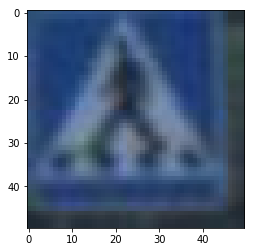

In [7]:
# Посмотрим, что выдаёт одна итерация DataLoader
batch = next(iter(signsTrainLoader))
img = batch['image'][0]
img = np.transpose(img, (1, 2, 0))

plt.imshow(img)

### Данные сильно несбалансированы (unbalanced dataset)
### Задача
    Взгляните на количество представителей каждого класса 
    К чему это может привести?
    
    Подумайте о вариантах исправления проблемы
#### upsampling, аугментация данных

In [8]:
df = dataset.signs_frame
classes_number = df['label'].nunique()
print('Classes number:', classes_number)
df.groupby('label')['file_name'].nunique()

Classes number: 17


label
100_SIGN                    62
110_SIGN                    18
30_SIGN                     30
50_SIGN                    118
60_SIGN                     19
70_SIGN                    150
80_SIGN                     61
90_SIGN                     16
GIVE_WAY                   143
NO_PARKING                  45
NO_STOPPING_NO_STANDING     51
OTHER                      322
PASS_EITHER_SIDE            19
PASS_RIGHT_SIDE            364
PEDESTRIAN_CROSSING        630
PRIORITY_ROAD              438
STOP                        17
Name: file_name, dtype: int64

## Создаём и обучаем сеть

In [0]:
import torch.nn as nn
import torch.nn.functional as F  # Functional
import torch
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np

train_on_gpu = torch.cuda.is_available()

In [0]:
layers_to_unfreeze = 0

# Ваш код здесь
model_extractor = models.vgg16(pretrained=True)

# замораживаем параметры (веса)
for param in list(model_extractor.parameters())[:-layers_to_unfreeze]:
    param.requires_grad = False

# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(in_features=25088, out_features=17, bias=True)

# Использовать ли GPU
if True:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.SGD(model_extractor.classifier.parameters(), lr=0.001, momentum=0.9)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [0]:
# Класс свёрточной нейронной сети
class SimpleConvNet(nn.Module):
    def __init__(self, class_number):
        # вызов конструктора предка
        super(SimpleConvNet, self).__init__()
        # необходмо заранее знать, сколько каналов у картинки (сейчас = 3),
        # которую будем подавать в сеть, больше ничего
        # про входящие картинки знать не нужно
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        
        self.fc1 = nn.Linear(16 * 9 * 9, 120)  # !!! 
        
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, class_number)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Подаём картинку на вход и увидим, сколько элементов на входе первого fully connected!
        # Подробнее замечание снизу (оно из прошлого семинара)
        # print(x.shape)
        ## ИЛИ ЖЕ МОЖНО ЭТО РАССЧИТАТЬ, НО ЭТО ДОЛЬШЕ
        
        x = x.view(-1, 16 * 9 * 9)  # !!! Аналог Flatten в keras
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # Функция акктивации отсутствует
        # torch.nn.CrossEntropyLoss разбирается с этим сам
        return x

In [17]:
classes_number

17

#### Примечание из прошлого семинара

Важное примечание: Вы можете заметить, что в строчках с #!!! есть не очень понятный сходу $9 * 9 * 16$. Это -- размерность картинки перед FC-слоями (H x W x C), тут её приходиться высчитывать вручную (в Keras, например, .Flatten() всё делает за Вас). Однако есть один лайфхак -- просто сделайте в forward() print(x.shape) (закомментированная строка). Вы увидите размер (batch_size, C, H, W) -- нужно перемножить все, кроме первого (batch_size), это и будет первая размерность Linear(), и именно в C H W нужно "развернуть" x перед подачей в Linear().

То есть нужно будет запустить цикл с обучением первый раз с print() и сделать после него break, посчитать размер, вписать его в нужные места и стереть print() и break.

In [0]:
# Создаём сеть
cnn = model_extractor.to(device)

In [29]:
# Взглянем на вывод
batch = next(iter(signsTrainLoader))
cnn(batch['image'].to(device))[0]

tensor([ -7.6051,  -8.6419,  -9.8919,  -5.2429,  -5.9827,  -9.1159,  -4.5496,
         -8.7586, -13.9575, -11.8585,  -4.4917, -10.4404, -15.0321,  -8.6438,
          8.2639, -11.5448, -11.2578], device='cuda:0',
       grad_fn=<SelectBackward>)

In [30]:
from tqdm import tqdm_notebook

# С помощью этого увидим, как сеть обучалась
history = {'loss':[], 'val_loss':[]}

# Выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# Выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

# Цикл обучения
i = 0
for epoch in tqdm_notebook(range(50)):

    running_loss = 0.0
    for batch in signsTrainLoader:
        
        # Так получаем текущий батч
        X_batch, y_batch = batch['image'].to(device), batch['label'].to(device)
        
        # Обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = cnn(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # Выведем текущий loss
        running_loss += loss.item()
        
        # Пишем в лог каждые 50 батчей
        if i % 50 == 49:
            batch = next(iter(signsValidationLoader))
            X_batch, y_batch = batch['image'].to(device), batch['label'].to(device)
            y_pred = cnn(X_batch)
            
            history['loss'].append(loss.item())
            history['val_loss'].append(loss_fn(y_pred, y_batch).item())
        
        # Выведем качество каждые 1000 батчей
        if i % 1000 == 999:
            print('[%d, %5d] loss: %.4f' % (epoch + 1, i + 1, running_loss))
            running_loss = 0
        i += 1

# Сохраним модель
torch.save(cnn.state_dict(), model_save_path)
print('Обучение закончено')

[13,  1000] loss: 0.0002
[26,  2000] loss: 0.0000
[38,  3000] loss: 0.0000

Обучение закончено


### Начертим кривые обучения

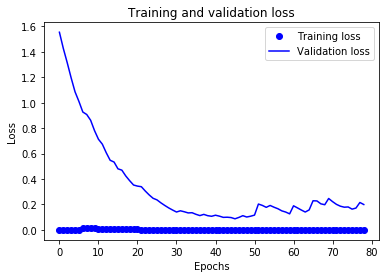

In [31]:
# Скользящее среднее
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.clf()
loss_values = smooth_curve(history['loss'])
val_loss_values = smooth_curve(history['val_loss'])
epochs = np.arange(len(loss_values))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Выведем confusion matrix

In [0]:
import itertools
    
# Воспользуемся функцией из документации matplotlib, выводящей confusion matrix 
# Source https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(16,11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()

Normalized confusion matrix


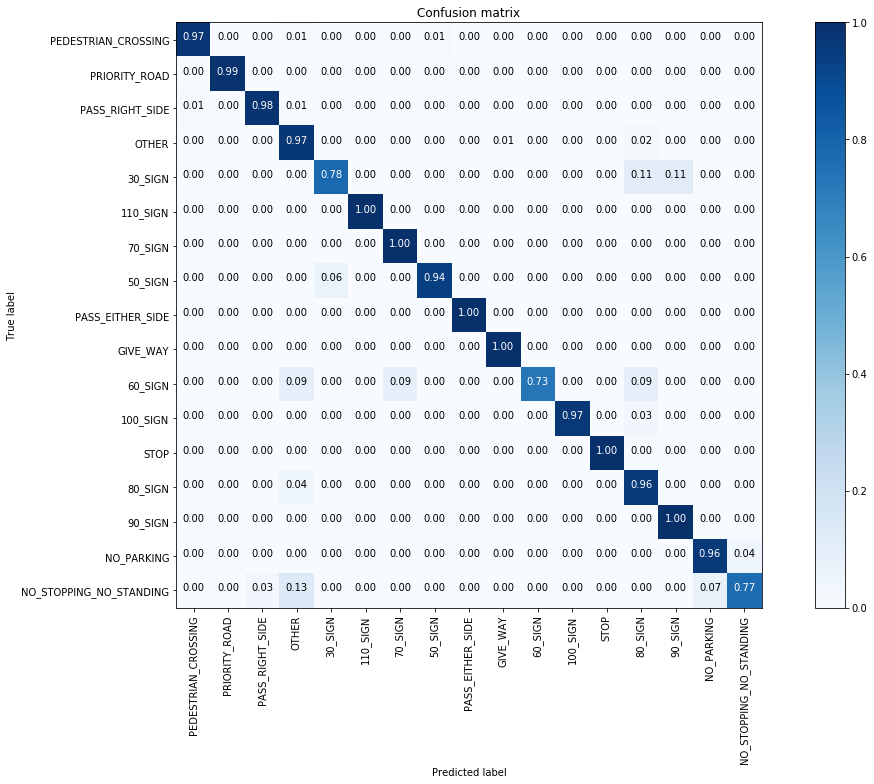

In [33]:
from sklearn.metrics import confusion_matrix

y_test_all = torch.Tensor().long()
predictions_all = torch.Tensor().long()

# Пройдём по всему validation датасету и запишем ответы сети
with torch.no_grad():
    for batch in signsValidationLoader:
        predictions = cnn(batch['image'].to(device))
        y_test = batch['label']
        _, predictions = torch.max(predictions.cpu(), 1)
        
        # Аналог append для list
        y_test_all = torch.cat((y_test_all, y_test), 0)
        predictions_all = torch.cat((predictions_all, predictions), 0)

feature_names = signsTrainLoader.dataset.labels

y_test_all = y_test_all.numpy()
predictions_all = predictions_all.numpy()

# Функция из sklearn, создаёт confusion матрицу
cm = confusion_matrix(y_test_all, predictions_all, np.arange(classes_number))
# Выведем её
plot_confusion_matrix(cm, dataset.labels, normalize=True)

### Задача
    - какие выводы можно сделать из confusion matrix?

### Выведем точность для каждого класса

In [34]:
class_correct = [0 for i in range(classes_number)]
class_total = [0 for i in range(classes_number)]

c = (predictions_all == y_test_all).squeeze()
for i in range(len(predictions_all)):
    label = predictions_all[i]            
    class_correct[label] += c[i].item()
    class_total[label] += 1

print(class_total)

for i in range(classes_number):
    print('Accuracy of %5s : %2d %%' % (
        (dataset.labels[i], (100 * class_correct[i] / class_total[i]) if class_total[i] != 0 else -1)))

[347, 210, 178, 139, 18, 8, 79, 48, 13, 70, 11, 31, 8, 27, 11, 24, 30]
Accuracy of PEDESTRIAN_CROSSING : 97 %
Accuracy of PRIORITY_ROAD : 98 %
Accuracy of PASS_RIGHT_SIDE : 98 %
Accuracy of OTHER : 97 %
Accuracy of 30_SIGN : 77 %
Accuracy of 110_SIGN : 100 %
Accuracy of 70_SIGN : 100 %
Accuracy of 50_SIGN : 93 %
Accuracy of PASS_EITHER_SIDE : 100 %
Accuracy of GIVE_WAY : 100 %
Accuracy of 60_SIGN : 72 %
Accuracy of 100_SIGN : 96 %
Accuracy of  STOP : 100 %
Accuracy of 80_SIGN : 96 %
Accuracy of 90_SIGN : 100 %
Accuracy of NO_PARKING : 95 %
Accuracy of NO_STOPPING_NO_STANDING : 76 %


### Задача
    - какая связь между confusion matrix и accuracy для каждого класса?
    
#### Числа на диагонали confusion matrix и есть эти accuracy

### Оценим качество на отдельных кадрах из validation'а

Gound-true: PRIORITY_ROAD
Prediction: PRIORITY_ROAD


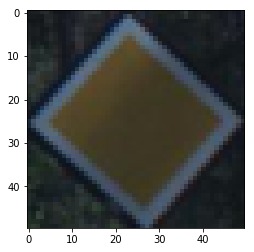

In [35]:
batch = next(iter(signsValidationLoader))
predictions = cnn(batch['image'].to(device))
y_test = batch['label']


#print(predictions, y_test)
_, predictions = torch.max(predictions, 1)

img = batch['image'][0]
img = np.transpose(img, (1, 2, 0))
plt.imshow(img)

print('Gound-true:', dataset.labels[batch['label'][0]])
print('Prediction:', dataset.labels[predictions[0]])

# Генерация файла ответов на test

In [36]:
from torch.utils.data import DataLoader

# Инициализируем загрузчик датасета (класс выше)
test_dataset = SignsDataset(data_path + 'test.csv', 
                       data_path + 'data//', 
                       torchvision.transforms.ToTensor(),
                       no_labels=True)


# DataLoader достаёт данные из dataset батчами
signsTestLoader = DataLoader(test_dataset, batch_size=1)

610 samples loaded


In [0]:
answer = []

for batch in signsTestLoader:
    predictions = cnn(batch['image'].to(device))
    _, predictions = torch.max(predictions, 1)
    answer.append(dataset.labels[predictions[0]])    

prediction_df = test_dataset.signs_frame
    
prediction_df['label'] = pd.Series(answer)
prediction_df.to_csv('my_submission.csv', index=False)

# Полезные ссылки

Лучшее руководство по matplotlib: https://matplotlib.org/faq/usage_faq.html

Автор: Мурашов Леонид